## Scratch way ##

Task 1

In [1]:
# 1.1 Critical Gas Parameters (Tc and Pc)
def specific_gravity(composition, MWs):
    """
        This function calculates specific gravity of
        the gas mixture through average molecular weight
    """

    AMW = 0
    for i in range(len(composition)):
        AMW += list(composition.values())[i] * list(MWs.values())[i]
    return AMW / 28.96


def Tpc_Ppc(sg, system):
    """
        This function is used to compute pseudo-critical
        temperature and pressure for the system based on 
        empirical correlations
    """

    if system == "natural gas system":
        Tpc = 168 + 325 * sg - 12.5 * sg**2
        Ppc = 677 + 15 * sg - 37.5 * sg**2
    elif system == "gas-condensate system":
        Tpc = 187 + 330 * sg - 71.5 * sg**2
        Ppc = 706 - 51.7 * sg - 11.1 * sg**2
    return Tpc, Ppc


#Input
composition = {'CO2': 0.02, 'N2': 0.01, 'C1': 0.85, 'C2': 0.04, 'C3': 0.03, 'i-C4': 0.03, 'n-C4': 0.02}
MWs = {'CO2': 44.01, 'N2': 28.01, 'C1': 16.04, 'C2': 30.07, 'C3': 44.09, 'i-C4': 58.12, 'n-C4': 58.12}

#Computation
sg = specific_gravity(composition, MWs)
system = "natural gas system"
Tpc, Ppc = Tpc_Ppc(sg, system)

#Output
print(f"Pseudo-critical temperature: {Tpc} °R")
print(f"Pseudo-critical pressure: {Ppc} psia")

Pseudo-critical temperature: 388.8844122483431 °R
Pseudo-critical pressure: 669.1847284577365 psia


In [2]:
# 1.2 Critical Parameter Correction due to Nonhydrocarbon Components (values have been obtained via library)

Tpc_corr = 345.325881907563
Ppc_corr = 791.8657765793805

print(f"Pseudo-critical_corrected temperature: {Tpc_corr}")
print(f"Pseudo-critical_corrected pressure: {Ppc_corr}")

Pseudo-critical_corrected temperature: 345.325881907563
Pseudo-critical_corrected pressure: 791.8657765793805


In [3]:
# 1.3 Reduced Parameters (Tr and Pr)
def Tpr_Ppr(Tres, Pres, Tpc, Ppc):   #T in Rankine; P in psia
    """
        This function calculates reduced temperature
        and pressure using reservoir and critical
        properties
    """

    return Tres / Tpc, Pres / Ppc


def convert_Farenheit_to_Rankine(Tres_F):
    """Converts Farenheit to Rankine"""
    
    return Tres_F + 460


#Input
Tres_F = 180 #deg F
Pres = 3000 #psia

#Computation
Tpr, Ppr = Tpr_Ppr(convert_Farenheit_to_Rankine(Tres_F), Pres, Tpc, Ppc)

#Output
print(f"Pseudo-reduced temperature: {Tpr}")
print(f"Pseudo-reduced pressure: {Ppr}")

Pseudo-reduced temperature: 1.645733230344274
Pseudo-reduced pressure: 4.483067040268643


In [4]:
# 1.4 z-factor using Hall Yarborough Method
import math

def newton_raphson(start, func, func_der):
    eps = 1e-3
    root = start
    limit = 1e+3
    i = 1
    while abs(func(root, X1, X2, X3, X4)) > eps:
        if i > limit:
            break
        i += 1
        root = root - func(root, X1, X2, X3, X4) / func_der(root, X1, X2, X3, X4)
    return root


def hall_yarborough(Ppr, Y, t):
    """
        This method of finding z-factor implements 
        iterative approach to estimate z-value just 
        as in Standing and Katz chart
    """
    z = (0.06125 * Ppr * t / Y) * math.exp(-1.2 * (1 - t)**2)
    return z


def obj(Y, X1, X2, X3, X4):
    return X1 + (Y + Y**2 + Y**3 + Y**4) / (1 - Y)**3 - X2 * Y**2 + X3 * Y**X4


def obj_der(Y, X1, X2, X3, X4):
    return (1 + 2 * Y + 3 * Y**2 + 4 * Y**3) / (1 - Y)**3 + 3 * (Y + Y**2 + Y**3 + Y**4) / (1 - Y)**4 - 2 * X2 * Y + X3 * X4 * Y**(X4 - 1)


t = 1 / Tpr
X1 = -0.06125 * Ppr * t * math.exp(-1.2 * (1 - t)**2)
X2 = 14.76 * t - 9.76 * t**2 + 4.58 * t**3
X3 = 90.7 * t - 242.2 * t**2 +42.4 * t**3
X4 = 2.18 + 2.82 * t

start = 0.0125 * Ppr * t * math.exp(-1.2 * (1 - t)**2)
Y = newton_raphson(start, obj, obj_der)

print(f"Compressibility factor: {hall_yarborough(Ppr, Y, t)}")


Compressibility factor: 0.8611441278796437


Task 2

In [5]:
# 2.1 Isothermal Gas Compressibility (Cg)
def dz_dp(p, dp=1e-5):
    """
    Numerical derivative of z-factor with respect to pressure.
    """
    return (hall_yarborough(Ppr + dp, Y, t) - hall_yarborough(Ppr, Y, t))/dp



def gas_compressibility(p):
    """
    Calculate gas compressibility c_g based on the given formula.
    """
    z = hall_yarborough(p, Y, t)
    dzdp = dz_dp(p)
    return (1 / p) - (1 / z) * dzdp



print(f"Isothermal Gas Compressibility: {gas_compressibility(Pres)}")

Isothermal Gas Compressibility: 7.271169343708861e-14


In [6]:
# 2.2 Formation Volume Factor (Bg)
def calculate_Bg(P, T, z):
    """
        Calculates gas formation volume factor
    """
    Bg = 0.02827 * z * T / P
    return Bg


T = convert_Farenheit_to_Rankine(Tres_F)
z = hall_yarborough(Ppr, Y, t)
print(f"Formation Volume Factor: {calculate_Bg(Pres, T, z)} ft3/scf")


Formation Volume Factor: 0.005193502825633605 ft3/scf


In [7]:
# 2.3 Gas Viscosity (μg)
def calculate_gas_viscosity(rho_g, AMW, T):
    """
        Calculate the gas viscosity (μg) using Lee et al. (1966) correlation.
    """
    K1 = (0.00094 + 2 * 10**-6 * AMW) * T**1.5 / (209 + 19 * AMW + T)
    X = 3.5 + (986 / T) + (0.01 * AMW)
    Y = 2.4 - (0.2 * X)
    mu_g = K1 * math.exp(X * rho_g**Y)

    return mu_g


rho_g = 0.01
AMW = specific_gravity(composition, MWs) * 28.96
T = convert_Farenheit_to_Rankine(Tres_F)


mu_g = calculate_gas_viscosity(rho_g, AMW, T)
print(f"Gas Viscosity: {mu_g:.6f} cP")



Gas Viscosity: 0.013006 cP


## Alternative way ##

Task 1  (use of ready library gascompressibility)

In [8]:
# 1.1 Critical Gas Parameters (Tc and Pc)
from gascompressibility.pseudocritical import Piper

Tpc = Piper().calc_Tpc(sg=0.7)
Ppc = Piper().calc_Ppc(sg=0.7)


print(f"Pseudo-critical temperature: {Tpc} °R")
print(f"Pseudo-critical pressure: {Ppc} psia")

Pseudo-critical temperature: 371.4335560823552 °R
Pseudo-critical pressure: 660.6569792741872 psia


In [9]:
# 1.2 Critical Parameter Correction due to Nonhydrocarbon Components
J = Piper().calc_J(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1)  # Stewart-Burkhardt-VOO parameter J, (°R/psia)
K = Piper().calc_K(sg=0.7, CO2=0.1, H2S=0.07, N2=0.1)  # Stewart-Burkhardt-VOO parameter K, (°R/psia^0.5)
Tpc_corr = K**2 / J
Ppc_corr = Tpc / J

print(f"Pseudo-critical_corrected temperature: {Tpc_corr} °R")
print(f"Pseudo-critical_corrected pressure: {Ppc_corr} psia")

Pseudo-critical_corrected temperature: 345.325881907563 °R
Pseudo-critical_corrected pressure: 791.8657765793805 psia


In [10]:
# 1.3 Reduced Parameters (Tr and Pr)
Tpr = Piper().calc_Tr(sg=0.7, T=75, CO2=0.1, H2S=0.07, N2=0.1)  # reduced pseudo-critical temperature, Tr (dimensionless)
Ppr = Piper().calc_Pr(sg=0.7, P=3000, CO2=0.1, H2S=0.07, N2=0.1)  # reduced pseudo-critical pressure, Pr (dimensionless)

print(f"Pseudo-reduced temperature: {Tpr}")
print(f"Pseudo-reduced pressure: {Ppr}")

Pseudo-reduced temperature: 1.5483056093175225
Pseudo-reduced pressure: 4.094911629367084


In [11]:
# 1.4 z-factor Using an Equation of State (EOS)

def z_factor(sg=0.7, T=75, P=3000, zmodel='kareem', pmodel='piper'):
    import gascompressibility as gc
    z = gc.calc_z(sg=0.7, T=75, P=3000, zmodel='kareem', pmodel='piper')
    return z
print(f"Compressibility factor: {z_factor()}")


Compressibility factor: 0.768516487876747


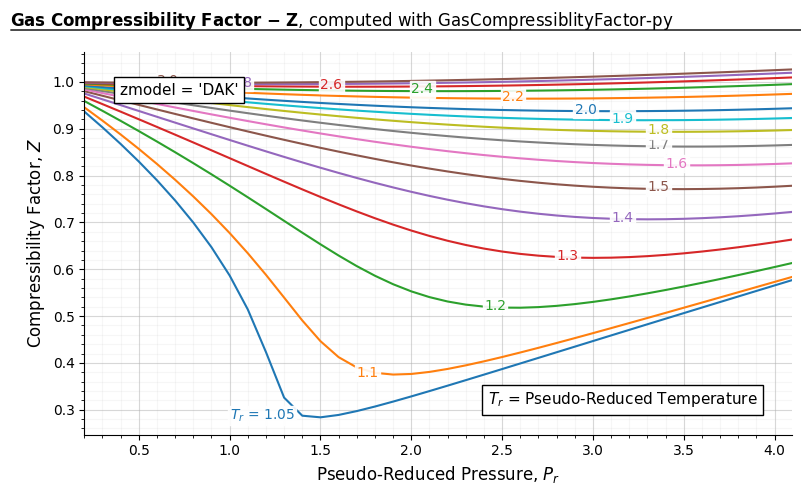

In [12]:
import gascompressibility as gc

result, fig, ax = gc.quickstart(zmodel='DAK', prmin=0.2, prmax=4.094911629367084)

Task 2

In [13]:
# 2.1 Isothermal Gas Compressibility (Cg)
def dz_dp(p, dp=1e-5):
    """
    Numerical derivative of z-factor with respect to pressure.
    """
    return (z_factor(P=(p + dp)) - z_factor(P=(p - dp)))/dp


def gas_compressibility(p):
    """
    Calculate gas compressibility c_g based on the given formula.
    """
    z = z_factor(P=p)
    dzdp = dz_dp(p)
    return (1 / p) - (1 / z) * dzdp


print(f"Isothermal Gas Compressibility: {gas_compressibility(Pres)}")

Isothermal Gas Compressibility: 0.0003333333333333333


In [14]:
# 2.2 Formation Volume Factor (Bg)

def calculate_Bg(P, T, z):
    """
        Calculate gas formation volume factor.
    """
    Bg = 0.02827 * z * T / P
    return Bg

T = convert_Farenheit_to_Rankine(Tres_F)
z=z_factor()
print(f"Formation Volume Factor: {calculate_Bg(Pres, T, z)} ft3/scf")



Formation Volume Factor: 0.004634871703952136 ft3/scf


In [15]:
# 2.3 Gas Viscosity (μg)
def calculate_gas_viscosity(rho_g, AMW, T):
    """
        Calculate the gas viscosity (μg) using Lee et al. (1966) correlation.
    """
    K1 = (0.00094 + 2 * 10**-6 * AMW) * T**1.5 / (209 + 19 * AMW + T)
    X = 3.5 + (986 / T) + (0.01 * AMW)
    Y = 2.4 - (0.2 * X)
    mu_g = K1 * math.exp(X * rho_g**Y)

    return mu_g


rho_g = 0.01
AMW = specific_gravity(composition, MWs) * 28.96
T = convert_Farenheit_to_Rankine(Tres_F)


mu_g = calculate_gas_viscosity(rho_g, AMW, T)
print(f"Gas Viscosity: {mu_g:.6f} cP")



Gas Viscosity: 0.013006 cP
